**Let's start with importing the necessary libraries, as follows:**

In [1]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


**First, we will plot an example input image of the game:**

(210, 160, 3)


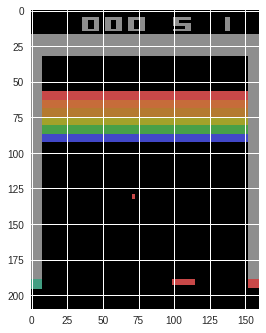

In [3]:
env = gym.make('BreakoutDeterministic-v4')
observation = env.reset()

for i in range(3):
  # The ball is released after 2 frames
  if i > 1:
    print(observation.shape)
    plt.imshow(observation)
    plt.show()
    
  # Get the next observation
  observation, _, _, _ = env.step(1)

  
## Example input image of Breakout by OpenAI

**Now, we can define a function that preprocesses the input data:**

In [0]:
def preprocess_frame(frame):
  frame = frame[30:200, 10:150]
  
  # grayscale frame and downsize by factor 2
  frame = frame[::2, ::2, 0]
  
  # set background to 0
  frame[frame == 144] = 0
  frame[frame == 109] = 0
  
  # set ball and paddles to 1
  frame[frame != 0] = 1
  
  return frame

**Let's output the preceding preprocessed image to give us an idea of what our algorithm will process:**

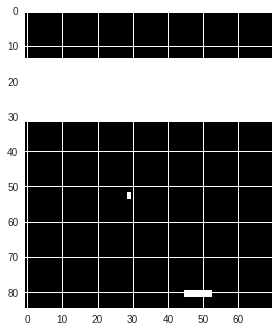

In [6]:
obs_preprocessed = preprocess_frame(observation)

plt.imshow(obs_preprocessed, cmap = 'gray')
plt.show()

## Preprocessed frame of Breakout

**For our deep Q-learning implementation, we need to define an agent that performs most of the tasks:**

In [0]:
class DQLAgent:
  def __init__(self, cols, rows, n_actions, batch_size = 32):
    self.state_size = (cols, rows, 4)
    self.n_actions = n_actions
    self.epsilon = 1.
    self.epsilon_start, self.epsilon_end = 1.0, 0.1
    self.exploration_steps = 1000000.
    self.epsilon_decay_step = (self.epsilon_start - self.epsilon_end) / self.exploration_steps
    self.batch_size = batch_size
    self.discount_factor = 0.99
    self.memory = deque(maxlen = 400000)
    self.model = self.build_model()
    self.target_model = self.build_model()
    self.optimizer = self.optimizer()
    self.avg_q_max, self.avg_loss = 0, 0
    
  
  def optimizer(self):
    a = K.placeholder(shape = (None, ), dtype = 'int32')
    y = K.placeholder(shape = (None, ), dtype = 'float32')
    
    py_x = self.model.output
    
    a_one_hot = K.one_hot(a, self.n_actions)
    q_value = K.sum(py_x * a_one_hot, axis = 1)
    error = K.abs(y - q_value)
    
    quadratic_part = K.clip(error, 0.0, 1.0)
    linear_part = error - quadratic_part
    loss = K.mean(0.5 * K.square(quadratic_part) + linear_part)
    
    opt = Adam(lr = 0.00025, epsilon = 0.01)
    updates = opt.get_updates(self.model.trainable_weights, [], loss)
    train = K.function([self.model.input, a, y], [loss], 
                       updates = updates)
    
    return train
  
  
  def build_model(self):
    model = Sequential()
    model.add(Conv2D(32, (8, 8), strides = (4, 4), activation = 'relu', input_shape = self.state_size))
    model.add(Conv2D(64, (4, 4), strides = (2, 2), activation = 'relu'))
    model.add(Conv2D(64, (3, 3), strides = (1, 1), activation = 'relu'))
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(self.n_actions))
    model.summary()
    return model
  
  
  def update_model(self):
    self.target_model.set_weights(self.model.get_weights())
    
  
  def action(self, history):
    history = np.float32(history / 255.0)
    if np.random.rand() <= self.epsilon:
      return random.randrange(self.n_actions)
    else:
      q_value = self.model.predict(history)
      return np.argmax(q_value[0])
    
  
  def replay(self, history, action, reward, next_history, dead):
    self.memory.append((history, action, reward, next_history, dead))
    
  
  def train(self):
    if len(self.memory) < self.batch_size:
      return
    if self.epsilon > self.epsilon_end:
      self.epsilon -= self.epsilon_decay_step
      
    mini_batch = random.sample(self.memory, self.batch_size)
    history = np.zeros((self.batch_size, self.state_size[0],
                        self.state_size[1], self.state_size[2]))
    next_history = np.zeros((self.batch_size, self.state_size[0],
                             self.state_size[1], self.state_size[2]))
    target = np.zeros((self.batch_size, ))
    action, reward, dead = [], [], []
    
    for i in range(self.batch_size):
      history[i] = np.float32(mini_batch[i][0] / 255.)
      next_history[i] = np.float32(mini_batch[i][3] / 255.)
      action.append(mini_batch[i][1])
      reward.append(mini_batch[i][2])
      dead.append(mini_batch[i][4])
      
    target_value = self.target_model.predict(next_history)
    
    for i in range(self.batch_size):
      if dead[i]:
        target[i] = reward[i]
      else: 
        target[i] = reward[i] + self.discount_factor * np.amax(target_value[i])
        
    loss = self.optimizer([history, action, target])
    self.avg_loss += loss[0]

**Next, we set the hyperparameters and some general settings and initialize our agent:**

In [8]:
env = gym.make('BreakoutDeterministic-v4')

# General settings
n_warmup_steps = 50000
update_model_rate = 10000
cols, rows = 85, 70
n_states = 4

# Hyperparameters
batch_size = 32

# Initialization
agent = DQLAgent(cols, rows, n_actions = 3)
scores, episodes = [], []
n_steps = 0

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 16, 32)        8224      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 7, 64)          32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 5, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2240)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1147392   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
Total params: 1,226,915
Trainable params: 1,226,915
Non-trainable para

**We are now ready to start training our model:**

In [12]:
while True:
  done = False
  dead = False
  step, score, start_life = 0, 0, 5
  observation = env.reset()
  
  state = preprocess_frame(observation).reshape(cols, rows)
  history = np.stack((state, state, state, state), axis = 2)
  history = np.reshape([history], (1, cols, rows, n_states))
  
  while not done:
    # env.render()
    n_steps += 1
    step += 1
    
    # Get action
    action = agent.action(history)
    observation, reward, done, info = env.step(action + 1)
    
    # Extract next state
    state_next = preprocess_frame(observation).reshape(cols, rows)
    state_next = np.reshape([state_next], (1, cols, rows, 1))
    history_next = np.append(state_next, history[:, :, :, :3], axis = 3)
    
    agent.avg_q_max += np.amax(agent.model.predict(history)[0])
    reward = np.clip(reward, -1., 1.)
    
    agent.replay(history, action, reward, history_next, dead)
    agent.train()
    
    if n_steps % update_model_rate == 0:
      agent.update_model()
    score += reward
    
    if dead:
      dead = False
    else:
      history = history_next
      
    if done:
      print('episode {:2d}; score: {:2.0f}; q {:2f}; loss {:2f}; steps {}'
            .format(n_steps, score, agent.avg_q_max / float(step), agent.avg_loss / float(step), step))
      
      agent.avg_q_max, agent.avg_loss = 0, 0
      
  # Save weights of model
  if n_steps % 1000 == 0:
    agent.model.save_weights("breakout_dql.h5")

episode 256; score:  3; q 0.113287; loss 0.004394; steps 255
episode 412; score:  1; q 0.113409; loss 0.005049; steps 156
episode 546; score:  0; q 0.111289; loss 0.003920; steps 134
episode 674; score:  0; q 0.113497; loss 0.003868; steps 128
episode 908; score:  3; q 0.113190; loss 0.003898; steps 234
episode 1078; score:  1; q 0.113888; loss 0.003729; steps 170
episode 1205; score:  0; q 0.111518; loss 0.004257; steps 127
episode 1531; score:  5; q 0.119345; loss 0.002856; steps 326
episode 1690; score:  1; q 0.119563; loss 0.004187; steps 159
episode 1893; score:  2; q 0.122206; loss 0.005254; steps 203
episode 2103; score:  2; q 0.121653; loss 0.003697; steps 210
episode 2264; score:  1; q 0.118511; loss 0.003759; steps 161
episode 2394; score:  0; q 0.116914; loss 0.004397; steps 130
episode 2566; score:  1; q 0.118428; loss 0.003794; steps 172
episode 2694; score:  0; q 0.119649; loss 0.004360; steps 128
episode 2867; score:  1; q 0.115643; loss 0.003409; steps 173
episode 3046;

KeyboardInterrupt: ignored

**When our algorithm scores well enough, we can stop training.**

**Let's see how our final model performs:**

In [15]:
env = gym.make('BreakoutDeterministic-v4')
agent = DQLAgent(cols, rows, n_actions = 3)

for i in range(5):
  observation = env.reset()
  
  state = preprocess_frame(observation).reshape(cols, rows)
  history = np.stack((state, state, state, state), axis = 2)
  history = np.reshape([history], (1, cols, rows, n_states))
  
  while not done:
    # env.render()
    action = agent.action(history)
    observation, reward, done, info = env.step(action + 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 20, 16, 32)        8224      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 9, 7, 64)          32832     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 5, 64)          36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 2240)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               1147392   
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 1539      
Total params: 1,226,915
Trainable params: 1,226,915
Non-trainable params: 0
_________________________________________________________________
